# CIFAR 10 Classification
As part of this exercise I will create an algorithm for image recognition. I will use CIFAR 10 dataset, which contains 60000 images of 10 classes. The dataset is already unified - all images are of the same size (32x32 pixels) and have 3 color channels (RGB).

## Downloading and preprocessing dataset
I will download a dataset from https://www.cs.toronto.edu/~kriz/cifar.html.

In [1]:
import wget
import tarfile
import os

def download_cifar10(dataset_url, dataset_name, dataset_folder):
    listdir = os.listdir()
    if dataset_name not in listdir and dataset_folder not in listdir:
        print("Downloading dataset")
        wget.download(dataset_url, dataset_name)
    print("The dataset is already downloaded")
        
def unpack_dataset(dataset_folder, dataset_name):
    if dataset_folder not in os.listdir():
        print("Unpacking dataset")
        tar = tarfile.open(dataset_name, "r:gz")
        tar.extractall()
        tar.close()
    print("The dataset already unpacked")

In [2]:
wd = "C:/Users/Magda/Desktop/Tooploox"
dataset_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
dataset_name = "dataset.tar.gz"
dataset_folder = "cifar-10-batches-py"

os.chdir(wd)

download_cifar10(dataset_url, dataset_name, dataset_folder)
unpack_dataset(dataset_folder, dataset_name)

The dataset is already downloaded
The dataset already unpacked


Ok, so the dataset is downloaded and unpacked. Now I need to load the data and preprocess them accordingly.

In [3]:
import numpy as np
import pickle

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def prepare_dataset(dataset_folder, training_size, batches_number, img_size, img_channels, classes_number):
    # preparing label names
    label_names = unpickle(file=dataset_folder + "/batches.meta")[b'label_names']
    label_names = [x.decode('utf-8') for x in label_names]
    label_dict = {i:label_names[i] for i in range(classes_number)}
    # preparing training dataset
    x_train = np.zeros(shape=[training_size, img_size, img_size, img_channels], dtype=int)
    y_train = np.zeros(shape=[training_size])
    
    for i in range(batches_number):
        # extractig training data from a batch
        batch = unpickle(file=dataset_folder + "/data_batch_" + str(0 + 1))
        x_batch, y_batch = batch[b'data'], batch[b'labels']
        batch_size = len(y_batch)
        # transforming X to a proper format
        x_batch = x_batch.reshape((batch_size, img_channels, img_size, img_size)).transpose(0,2,3,1)
        # adding data to training dataset
        x_train[batch_size*i : batch_size*i + batch_size] = x_batch
        y_train[batch_size*i : batch_size*i + batch_size] = y_batch 
    
    # naming training labels
    labels_train = [label_dict[i] for i in y_train]
    # preparing test dataset
    test = unpickle(file=dataset_folder + "/test_batch")
    x_test, y_test = test[b'data'], test[b'labels']
    # transforming X to a proper format
    x_test = x_test.astype(int).reshape((len(y_test), img_channels, img_size, img_size)).transpose(0,2,3,1)
    # naming test labels
    labels_test = [label_dict[i] for i in y_test]
    
    return x_train, x_test, np.array(labels_train), np.array(labels_test), label_dict

In [4]:
batches_number = 5
classes_number = 10
training_size = 50000
test_size = 10000
img_channels, img_size = 3, 32

x_train, x_test, train_labels, test_labels, label_dict = prepare_dataset(dataset_folder, training_size, batches_number, img_size, img_channels, classes_number)

Now the data should be ready for modelling. However, before we will get to excited I want to check whether the dataset was in fact properly prepared. In order to check on the data I will display 10 random images from every category.

In [5]:
import matplotlib.pyplot as plt

def plot_random_images(classes_number,image_displayed, train_labels, x_train, label_dict):
    fig, axes = plt.subplots(classes_number,image_displayed,figsize=(image_displayed,classes_number))
    for i in range(classes_number):
        # draw random sample of images from a class
        indicies = np.argwhere(train_labels == label_dict[i])[:,0]
        display = np.random.choice(indicies, image_displayed)
        for j in range(image_displayed):
            # display images
            axes[i][j].set_axis_off()
            axes[i][j].imshow(x_train[display[j]])

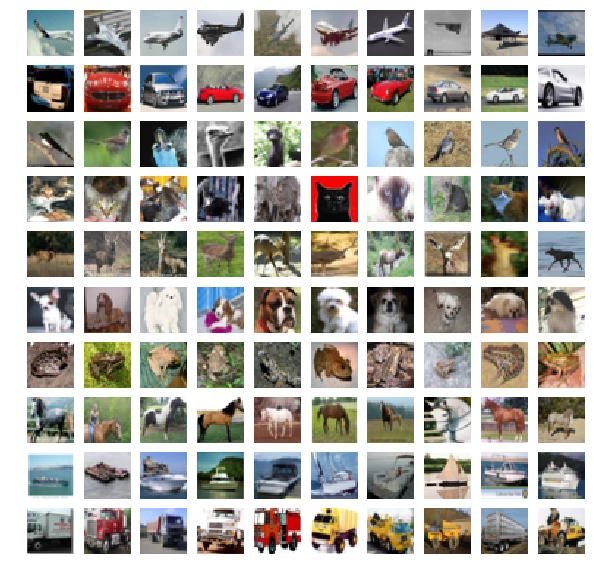

In [6]:
fig_size = 10
image_displayed = 10

plot_random_images(classes_number,image_displayed, train_labels, x_train, label_dict)

## Feature extraction
In order to be able to classify an image, first I need to recognize and extract its features. I will use two different algorithms to do that. First one will be HoG (Histogram of Oriented Gradients) descriptor and the second one will be Inception-v3.

### HoG Descriptor
HoG descriptors are mainly used to describe the structural shape and appearance of an object in an image. This method was designed for detecting humans on pictures. In this exercise it will serve as a benchmark for embeddings obtained from Inception-v3.

In [7]:
from skimage.feature import hog

def extract_hog_features(dataset_size, dataset):
    features = []
    for i in range(dataset_size):
        fd = hog(dataset[i,], orientations=4, pixels_per_cell=(2, 2), cells_per_block=(1, 1), feature_vector=True, multichannel=True, block_norm='L2-Hys')
        features.append(fd)
    return np.array(features)

In [8]:
hog_train_features = extract_hog_features(training_size, x_train)
hog_test_features = extract_hog_features(test_size, x_test)

### Inception-v3
Inception-v3 is a convolutional neural network trained on ImageNet dataset to recognize images of 1000 classes. Its architecture consists of two parts - the first one containing convolutional and pooling layers is designed for feature detection. The second part with fully connected layers is desined for images classification based on the information from the first part.

For my exercise I do not want to use Inception-v3 for classification. I want to use it just for feature extraction. Considering this, the most reasonable choice is to use the whole architecture created for this purpose. To create embeddings of images in CIFAR 10 I will use the last layer in the Inception-v3 part designed for feature detection, which is called "pool_3". Its output is a vector with 2048 values.

In [9]:
from tensorflow.python.platform import gfile
import tensorflow as tf
import pandas as pd

def import_inception(model_filename):
    with gfile.FastGFile(model_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        tf.import_graph_def(graph_def, name='')
        
def extract_cnn_features(dataset_size, dataset, pool_3_features):
    features = np.empty([dataset_size, pool_3_features], dtype='float32')
    with tf.Session() as sess:    
        pool_3_tensor = sess.graph.get_tensor_by_name('pool_3:0')
        for i in range(dataset_size):
            exctract = sess.run(pool_3_tensor, {"DecodeJpeg:0":dataset[i, :]})
            features[i, :] = np.squeeze(exctract)
    return features

H:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [10]:
model_filename ='inception_v3/classify_image_graph_def.pb'
pool_3_features = 2048

import_inception(model_filename)
#cnn_train_features = extract_cnn_features(training_size, x_train, pool_3_features)
#np.savetxt('traindata.csv', cnn_train_features, delimiter=',')
#cnn_test_features = extract_cnn_features(test_size, x_test, pool_3_features)
#np.savetxt('testdata.csv', cnn_train_features, delimiter=',')

# I prepared the embedding before so now I will import them from csv files. I use pandas for reading csv as this is way faster than numpy
cnn_train_features = pd.read_csv('traindata.csv', header=None, delimiter=',').as_matrix()
cnn_test_features = pd.read_csv('testdata.csv', header=None, delimiter=',').as_matrix()

## Embeddings comparison

A crucial attribute of good embeddings is that vector representations of images from the same class are quite similar while being most different for images from different categories. As vector representations are multidimentional it is impossible to visually assess whether the embeddings created for CIFAR 10 dataset fullfil this assumption. However, I will use a dimentionality reduction algorithms, which will let me to visualise embeddings obtained from HoG and Inception-v3 and to compare them.

There are two popular algorithms for dimentionality reduction - PCA and T-SNE. T-SNE is based on t-Student distribution. Thanks to that it is able to reduce the density of the observations in the plot, which makes it more readible. However, it requires much more operations and takes much more time than PCA. To keep the balance between computational time and the readability of the plot I will use both algorithms. First I will reduce the representation vectors to 64 values with PCA and then I will use T-SNE to reduce the dimentionality further to 2 values.

In [11]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns

def reduce_dimentionality(pca_output_components, n_iter, random_state, features):
    pca = PCA(n_components=pca_output_components)
    pca_emb = pca.fit_transform(features)
    tsne = TSNE(n_components=2, random_state=random_state, verbose=0, n_iter=n_iter)
    reduced_emb = tsne.fit_transform(pca_emb)
    return reduced_emb

def visualise_embeddings(reduced_emb, labels, title):
    reduced_features = pd.DataFrame(reduced_emb)
    reduced_features['class'] = labels
    plot = sns.pairplot(x_vars=[0], y_vars=[1], data=reduced_features, hue='class', size=10, markers="x")
    plot.fig.suptitle(title)

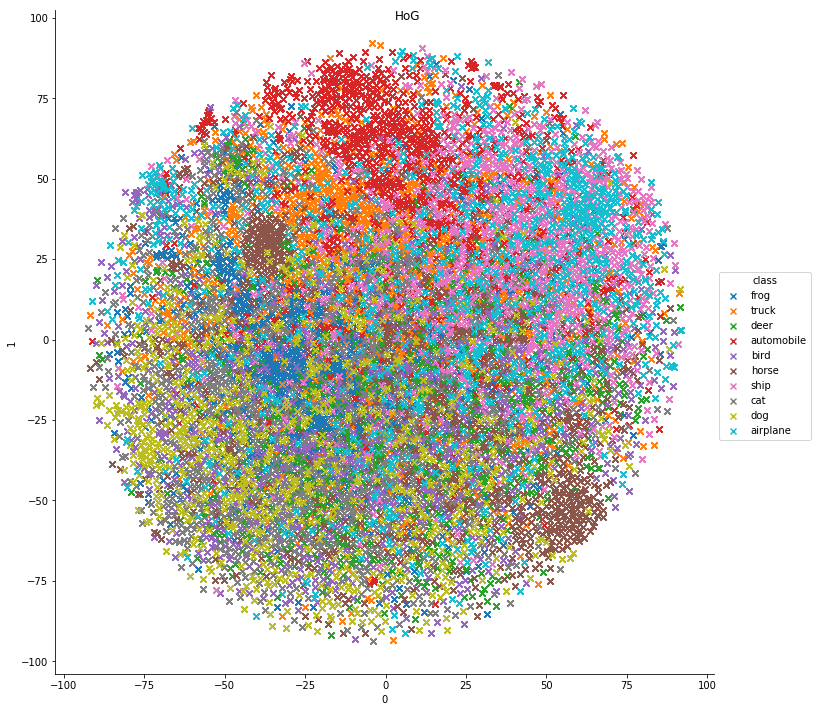

In [12]:
hog_reduced_emb = reduce_dimentionality(pca_output_components=64, n_iter=1000, random_state=314, features=hog_train_features)
visualise_embeddings(hog_reduced_emb, train_labels, title='HoG')

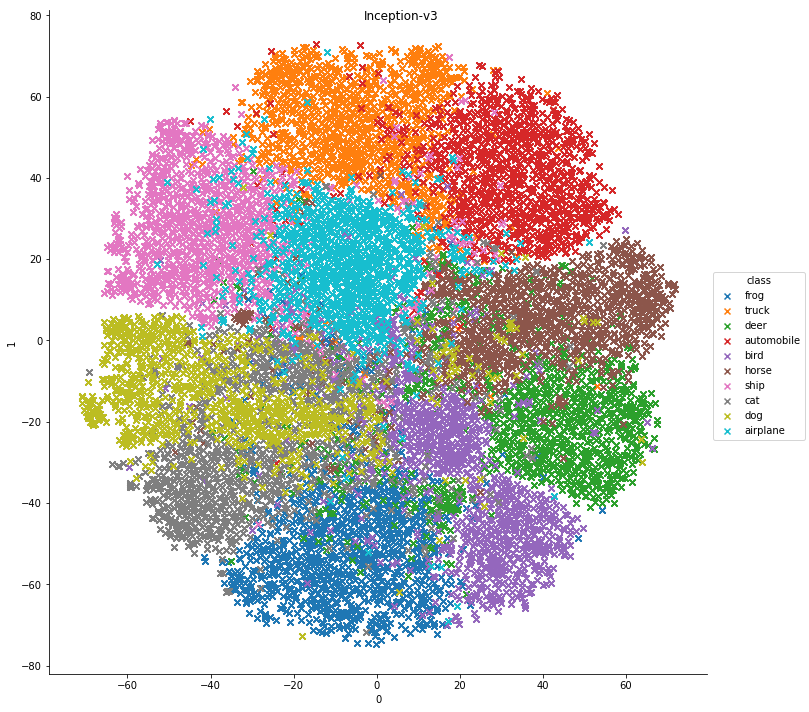

In [13]:
cnn_reduced_emb = reduce_dimentionality(pca_output_components=64, n_iter=1000, random_state=314, features=cnn_train_features)
visualise_embeddings(cnn_reduced_emb, train_labels, title='Inception-v3')

The Inception-v3 embeddings are performing much better than HoG embeddings. Although not all observations were perfectly groupped by Inception-v3, especially cats and dogs images are partially mixed, there are obvious boundaries between classes. In case of HoG embeddings there are some groups that are partially separeted (eg. horses or automobiles) but most classess are mixed. However, when we look closely, we can see that HoG embeddings were able to detect some similarities between images. Images of automobiles and trucks are mixed but they are separated from other classes. Similarly airplanes and ships. The reason behind HoG's poor performance could be the size of the images, which did not allow the algorithm for sufficient feature detection.

## Classification
The aim of this exercise is to find the best classificator of CIFAR 10 images. We already have vector representations of the images but now we need to train a model that will predict the class of an image. SVM is a popular algorithm used for such purpose. However, its efficiency depends on the implementation. The SMV implemented in libSVM library allows to use non-linear kernel but with such big dataset it would be extremly slow and training could take hours. I decided to use SVM implemented in liblinear library, which does not allow to use non-linear kernel and does not predict probabilities but it is much faster than libSVM implementation.

The classification accuracy of SVM depends on the used parameters. In libnear implementation the only reasonable parameter to test is parameter C, which is a penalty of an error term. Thge defalut parameter C is equal to 1 but it should be decreased when in the dataset there are a lot of noisy observations, which is the case in this exercise. To find optimal parameter C I will use a grid search algorithm based on 3 fold cross-validation implemented in Scikit-learn library.

Looking for the best SVM settings I tried to normalize data with max-min scaler, so that one feature did not dominate the classification algorithm. However, the results obtained with normalized data were worse so I decided to use the raw data.

In [14]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

def train_linear_svm(c_values, refit, n_jobs, train_features, labels):   
    parameters = {'C':c_values}
    linear_svc = svm.LinearSVC()
    svc = GridSearchCV(linear_svc, parameters, scoring='accuracy', refit=refit, n_jobs=n_jobs, verbose = 1)
    svc.fit(train_features, labels)
    return svc

#def normalizing_data(features):
#    min_max_scaler = preprocessing.MinMaxScaler()
#    norm_features = min_max_scaler.fit_transform(features)
#    return norm_features

In [15]:
cnn_svc = train_linear_svm([0.0001, 0.001, 0.01, 0.1, 1], False, 3, cnn_train_features, train_labels)
print(cnn_svc.cv_results_['mean_test_score'])

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:  6.8min finished


[0.90164 0.95144 0.99578 1.      1.     ]


In [16]:
hog_svc = train_linear_svm([0.0001, 0.001, 0.01, 0.1, 1], False, 3, hog_train_features, train_labels)
print(hog_svc.cv_results_['mean_test_score'])

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[0.50042 0.5602  0.59196 0.609   0.60256]


[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:  8.9min finished


According to the results of grid search the best C parameters for SVM trained on Inception-v3 embeddings are 0.1 and 1 - their accuracy score equals 1. However, it is not always obvious that the algorithm with the best accuracy score should be chosen, as there is always a risk of overfitting. I decided to choose the C parameter equal to 0.001 as it still has great accuracy but it is not perfectly fitted to the training dataset. In case of HoG embeddings the SVM model is far from being perfectly fitted to the training dataset so I will chose the parameter that gives the best accuracy - C equal to 0.1.

Now let's check the accuracy on the test dataset.

In [17]:
cnn_linear_svc = svm.LinearSVC(C = 0.001)
cnn_linear_svc.fit(cnn_train_features, train_labels)
cnn_pred = cnn_linear_svc.predict(cnn_test_features)

hog_linear_svc = svm.LinearSVC(C = 0.1)
hog_linear_svc.fit(hog_train_features, train_labels)
hog_pred = hog_linear_svc.predict(hog_test_features)

In [20]:
from sklearn.metrics import accuracy_score

print('Inception-v3 accuracy:', accuracy_score(test_labels, cnn_pred))
print('HoG accuracy:', accuracy_score(test_labels, hog_pred))

Inception-v3 accuracy: 0.888
HoG accuracy: 0.3244


Well, accuracy on the test dataset is really good for Inception-v3 embeddings. It makes it to the top 33 results obtained from all over the world. However, the accuracy on the HoG embeddings is extremly poor. It is still better than a random classification (for 10 classess random classification should have accuracy around 0.1) but it is far from being sufficient.

The accuracy of prediction on Inception-v3 embeddings probably could be even higher with more fancy classification architecture. My idea was to start from bagging used with SVM algorithm. It would work like this:
- draw N random samples from the training dataset
- build a separate SVM model on each sample (I wanted to try non-linear kernel as here I can manipulate with the size of the sample. If each sample had e.g. 5000 observations, non-linear SVM would calculate much faster. It could detect non-linear dependencies between classes and calculate certainity of prediction, which could lead to better predictions)
- ensemble all SVM models by linear regression (with calculated probabilities) or by voting.

Next I wanted to try similar architectrure but with additional feature sampling. Random forest algorithm is based on similar architecture and it performs well.

Those two architectures could decrease the accuracy as there are less data points and features (in the second architecture) in every model. However, it would allow me to use non-linear kernel and better loss function (cross-entropy, which not only focuses on the accuracy of prediction but also on the confidence of this prediction. Sometimes it is better to use a model with lower accuracy on training dataset but with higher level of confidence of predictions because such model may work better on test dataset). With sufficient number of ensembled algorithms it could decrease the variance of the model and thus increase the accuracy of predictions on test dataset.

Another idea was to use different classification algorithms (such as SVM, random forrest, neural network, etc.) on different samples from the training dataset and then ensebling them again with linear regression or voting.

Unfortunatelly I did not have enough time to explore those ideas.